#Clasificador de imágenes

En este proyecto se quiere crear una red neuronal que pueda, dado un conjunto de imágenes, identificar cada una en una categoría entre varias dadas.

## Librerias utilizadas
En este notebook se utilizan las librerías que se observan en la siguiente celda de código, destacando especialmente torch y torchvision, que son las principales librerías utilizadas para el entrenamiento y definición de las redes neuronales creadas.

In [1]:
import os
import torch
import random
import numpy as np
import pandas
import shutil
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
import torch.nn.functional as F
from torchvision.io import decode_image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

## Conjunto de datos

Para entrenar la red neuronal del clasificador de imagenes se ha escogido el conjunto de datos Skin Disease Dataset (https://www.kaggle.com/datasets/pacificrm/skindiseasedataset?resource=download ), que recoge múltiples imágenes de 22 enfermedades dermatológicas. Este dataset esta dividido en dos conjuntos de imágenes (test y train), frente a los tres necesarios para el desarrollo del clasificador, por lo que se elabora un script auxiliar para extraer varias imágenes del conjunto de entrenamiento para obtener un conjunto de validación (El script auxiliar se incluye en el repositorio, incluyendo las instrucciones necesarias para ejecutarlo y obtener un conjento de imagenes igual al usado durante la creación del proyecto). Para una mayor simplicidad en el entrenamiento de la red, se escoge un subconjunto de 10 de las enfermedades recogidas, de manera que se define la estructura de la red sobre el subconjunto y posteriormente se aplica sobre el conjunto completo.

Para cargar los datos en la red neuronal se crea una clase que hereda del Dataset de Pytorch (SkinDiseaseDataset), de manera que se pueden usar los dataloaders de Pytorch a pesar de que la estructura de los directorios sea diferente a la estándar.

In [2]:
class SkinDiseaseDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.labels_map={}
        labels_list=[]
        num=0
        for dir in os.listdir(self.img_dir):
            category=dir
            self.labels_map[num]=category
            for file in os.listdir(os.path.join(img_dir, dir)):
                labels_list.append((file, num))
            num+=1
        self.img_labels=pandas.DataFrame.from_records(labels_list)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.labels_map[self.img_labels.iloc[idx, 1]], self.img_labels.iloc[idx, 0])
        image = decode_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

La siguiente celda de código se utiliza para cargar el conjunto de imágenes de google drive al entorno de ejecución de google colab, de forma que no se pierde rendimiento al descargar las imagenes individualmente de google drive durante el entrenamiento de la red.

Es importante saber que para la ejecución de este cuaderno no se debe ejecutar para probar este cuaderno localmente, ya que depende de la ubicación de las imagenes en el sistema en el que se ejecuta.

In [3]:
if not os.path.exists("/content/resources.zip"): shutil.copy("/content/drive/MyDrive/resources.zip", "/content/")
if not os.path.exists("/content/resources"): shutil.unpack_archive("/content/resources.zip", "/content/resources")

##Entrenamiento y evaluación

En la siguiente celda se incluye un conjunto de funciones desarrolladas para entrenar y evaluar los modelos desarrollados, incluyéndose la creación de gráficos para mostrar el proceso de entrenamiento y los resultados de la evaluación de la red.

In [4]:
def train(model, dataset, EPOCHS, batch_size, optimizer, criterion, device, transform):
    train_dataset=SkinDiseaseDataset(os.path.join(dataset, "train"), transform=transform)
    train_loader=DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_dataset=SkinDiseaseDataset(os.path.join(dataset, "validation"), transform=transform)
    val_loader=DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    history = {
        'train_loss': [],
        'train_acc': [],
        'dev_loss': [],
        'dev_acc': [],
    }

    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            n_classes = outputs.shape[1]
            labels_one_hot = F.one_hot(labels, num_classes=n_classes).float()

            loss = criterion(outputs, labels_one_hot)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        avg_train_loss = running_loss / max(1, len(train_loader))
        train_acc = 100.0 * correct / max(1, total)

        model.eval()
        dev_running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                n_classes = outputs.shape[1]
                labels_one_hot = F.one_hot(labels, num_classes=n_classes).float()
                dev_loss = criterion(outputs, labels_one_hot)
                dev_running_loss += dev_loss.item()
        avg_dev_loss = dev_running_loss / max(1, len(val_loader))

        dev_acc = evaluate(model, device, os.path.join(dataset, "validation"), batch_size, transform)[0]

        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_acc)
        history['dev_loss'].append(avg_dev_loss)
        history['dev_acc'].append(dev_acc)

        print(f'[Epoch {epoch + 1}] '
              f'train_loss: {avg_train_loss:.3f} | train_acc: {train_acc:.2f}% | '
              f'dev_loss: {avg_dev_loss:.3f} | dev_acc: {dev_acc:.2f}%')

    return model, history

def evaluate(model, device, data, BATCH_SIZE, transform):
    test_dataset=SkinDiseaseDataset(data, transform=transform)
    test_loader=DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    model.eval()
    correct = 0
    total = test_loader.dataset.__len__()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    cm = confusion_matrix(all_labels, all_preds)
    accuracy = 100 * correct / total if total > 0 else 0.0
    return accuracy, cm

def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['dev_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['dev_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

def print_cm(cm, classes):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def runNN(model, DEVICE, data, epochs, BATCH_SIZE, optimizer, loss, transform):
    classes=[]
    for dir in os.listdir(os.path.join(data, "test")): classes.append(dir)
    model, history=train(model, data, epochs, BATCH_SIZE, optimizer, loss, DEVICE, transform)
    accuracy, cm=evaluate(model, DEVICE, os.path.join(data, "test"), BATCH_SIZE, transform)
    print(f"eval_acc: {accuracy:.2f}%")
    plot_training_history(history)
    print_cm(cm, classes)

## Redes creadas

A partir de la siguiente celda se realizan los distintos experimentos en los que se desarrollan distintas redes y se prueban frente al conjunto de datos.

Cabe destacar que para el entrenamiento de la red neuronal, se requiere que todas las imágenes sean del mismo tamaño para determinar el número de entradas. Puesto que el dataset contiene imágenes de distintos tamaños, las imágenes se reescalan mediante transforms.resize en las transformaciones. La primera idea es escalar las imágenes al tamaño máximo en tanto altura como anchura, de manera que se mantiene la fidelidad de las imágenes. Para hallar el tamaño al que se debe reescalar las imágenes, se elabora un script auxiliar que se halla en el repositorio, que devuelve las dimensiones máximas de altura y anchura de las imágenes del dataset, así como el formato de estas. Tras la ejecución de este script, se descubre que la altura máxima es de 8192 pixeles, la anchura máxima es de 8688 pixeles y que todas las imagenes están en formato RGB. Por tanto, la red neuronal tendría 3\*8192\*8688 entradas, o aproximadamente 213 millones de entradas. Debido al gran número de entradas, surgen problemas de memoria debido a que no hay suficiente espacio para guardar todos los pesos (si la siguiente capa tuviese solo 32 neuronas, ocuparían 27GB de ram, lo cuál hace imposible crear una red del tamaño suficiente para clasificar las imágenes en un hardware disponible para uso académico), por lo que en su lugar se prefiere reducir el tamaño de las imágenes para tener una capa de entrada más razonable. Como primera estimación, se reducen las imágenes a un 1% de lo tamaños máximos, de forma que quedan 3\*82\*87 entradas (21402).

### Experimento 1: Red simple

En primer lugar, se crea una red no convolutiva para servir de base para los futuros experimentos y tener una estimación inicial de los resultados de esperables.

[Epoch 1] train_loss: 2.337 | train_acc: 12.26% | dev_loss: 2.318 | dev_acc: 14.26%
[Epoch 2] train_loss: 2.337 | train_acc: 12.38% | dev_loss: 2.318 | dev_acc: 14.26%
[Epoch 3] train_loss: 2.337 | train_acc: 12.38% | dev_loss: 2.319 | dev_acc: 14.26%
[Epoch 4] train_loss: 2.337 | train_acc: 12.38% | dev_loss: 2.319 | dev_acc: 14.26%
[Epoch 5] train_loss: 2.337 | train_acc: 12.38% | dev_loss: 2.318 | dev_acc: 14.26%
eval_acc: 13.04%


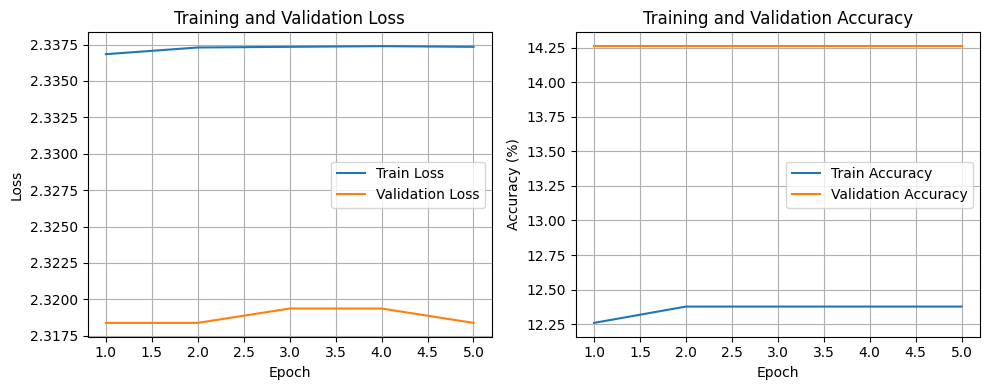

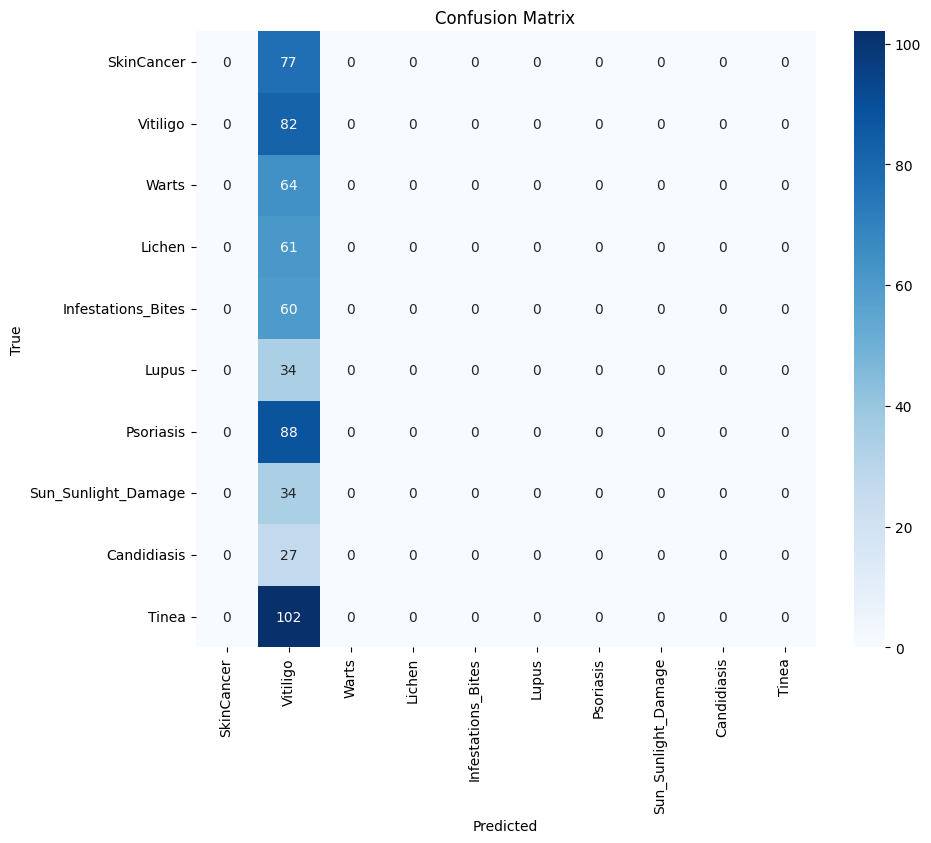

In [ ]:
class SimpleNetwork(nn.Module):
    def __init__(self):
        super(SimpleNetwork, self).__init__()
        self.fc1=nn.LazyLinear(8192)
        self.fc2=nn.LazyLinear(2048)
        self.fc3=nn.LazyLinear(512)
        self.fc4=nn.LazyLinear(10)
        self.activation=nn.Sigmoid()
        self.softmax=nn.Softmax(dim=1)

    def forward(self, x):
        x=x.view(x.size(0), -1)
        x=self.fc1(x)
        x=self.fc2(self.activation(x))
        x=self.fc3(self.activation(x))
        x=self.fc4(self.activation(x))
        return self.softmax(x)

seed_everything(0)
torch.cuda.empty_cache()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=SimpleNetwork().to(DEVICE)
runNN(model, DEVICE, os.path.join("resources", "resources", "SkinDisease(10 clases)"), 5, 32, torch.optim.Adam(model.parameters(), lr=1), torch.nn.CrossEntropyLoss(), transforms.Compose([transforms.ToPILImage(), transforms.Resize((82, 87)), transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

Se observan ratios de acierto bastante bajos, por debajo de un 15% tanto en entrenamiento, validación y evaluación. Además, en la matriz de confusión se observa que la red solo responde una de las categorías, por lo que la red no hace más que escoger una respuesta y esperar que esta sea la correcta.

Estos resultados evidencian las necesidad de utilizar redes convolutivas en problemas de clasificación de imagenes.

###Experimento 2: Red convolutiva

Se añade una capa convolutiva y una capa de pooling al modelo para así mejorar la identificación de las imágenes.

[Epoch 1] train_loss: 215.803 | train_acc: 11.51% | dev_loss: 79.930 | dev_acc: 6.21%
[Epoch 2] train_loss: 155.609 | train_acc: 11.53% | dev_loss: 144.198 | dev_acc: 14.26%
[Epoch 3] train_loss: 160.358 | train_acc: 10.98% | dev_loss: 145.824 | dev_acc: 10.57%
[Epoch 4] train_loss: 158.125 | train_acc: 12.34% | dev_loss: 170.358 | dev_acc: 10.57%
[Epoch 5] train_loss: 153.997 | train_acc: 11.24% | dev_loss: 164.176 | dev_acc: 6.21%
eval_acc: 5.41%


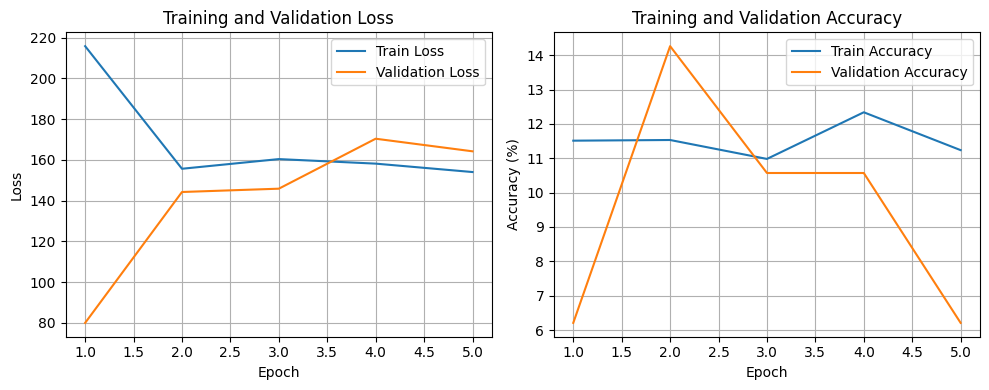

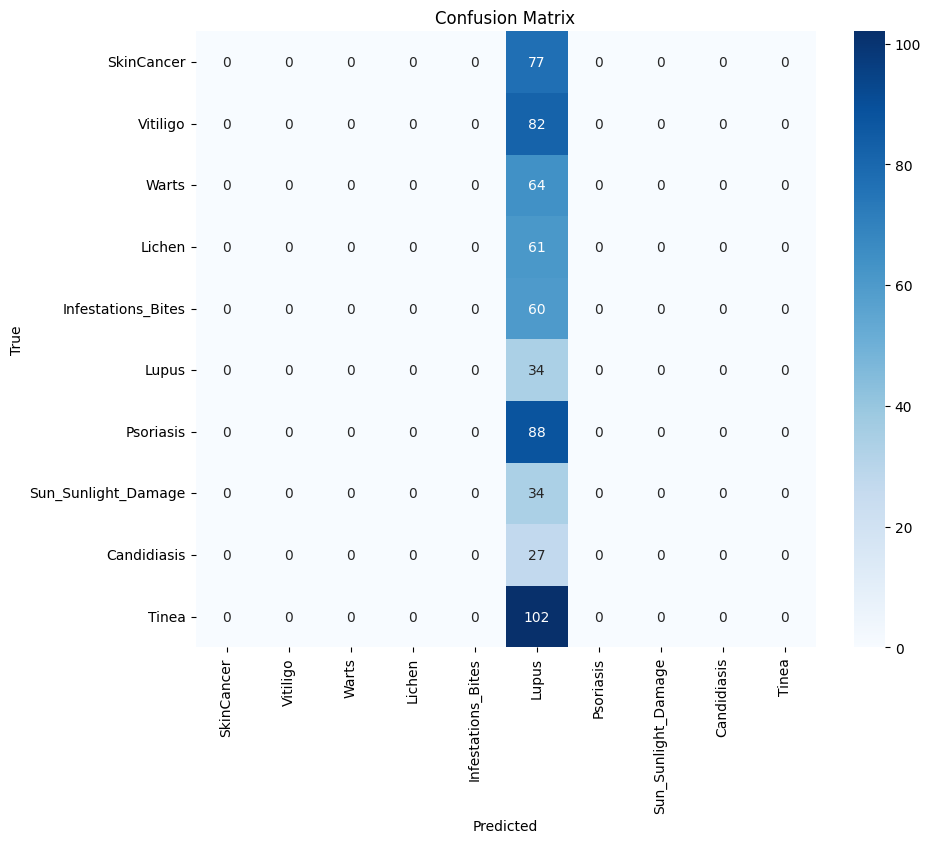

In [ ]:
class ConvNetwork(nn.Module):
    def __init__(self):
        super(ConvNetwork, self).__init__()
        self.fc1=nn.LazyLinear(8192)
        self.fc2=nn.LazyLinear(2048)
        self.fc3=nn.LazyLinear(512)
        self.fc4=nn.LazyLinear(10)
        self.conv1=nn.Conv2d(3, 16, 3)
        self.pool=nn.MaxPool2d(2, 2)
        self.activation=nn.Sigmoid()

    def forward(self, x):
        x=self.pool(self.activation(self.conv1(x)))
        x=x.view(x.size(0), -1)
        x=self.fc1(x)
        x=self.fc2(self.activation(x))
        x=self.fc3(self.activation(x))
        x=self.fc4(self.activation(x))
        return x

seed_everything(0)
torch.cuda.empty_cache()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=ConvNetwork().to(DEVICE)
runNN(model, DEVICE, os.path.join("resources", "resources", "SkinDisease(10 clases)"), 5, 32, torch.optim.Adam(model.parameters(), lr=1), torch.nn.CrossEntropyLoss(), transforms.Compose([transforms.ToPILImage(), transforms.Resize((82, 87)), transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

Los resultados son peores que los de la red no convolutiva, mostrando un comportamiento similar pero con una mayor perdida durante el entrenamiento.

### Experimento 3: Función tangente

Para intentar corregir el comportamiento de la red (escoger y esperar que la respuesta sea correcto) se sustituya la función de activación por la función tangente. De esta manera, la activación de las neuronas afecta en mayor medida al resultado y por tanto aumentando el resultado de la función de perdida, de tal manera que intentar responder siempre lo mismo no sea una estrategia viable.

[Epoch 1] train_loss: 296.747 | train_acc: 11.81% | dev_loss: 185.796 | dev_acc: 11.24%
[Epoch 2] train_loss: 275.290 | train_acc: 11.90% | dev_loss: 356.440 | dev_acc: 9.56%
[Epoch 3] train_loss: 227.345 | train_acc: 11.22% | dev_loss: 228.620 | dev_acc: 6.88%
[Epoch 4] train_loss: 211.676 | train_acc: 11.92% | dev_loss: 207.916 | dev_acc: 19.30%
[Epoch 5] train_loss: 187.484 | train_acc: 12.12% | dev_loss: 118.458 | dev_acc: 10.57%
eval_acc: 10.33%


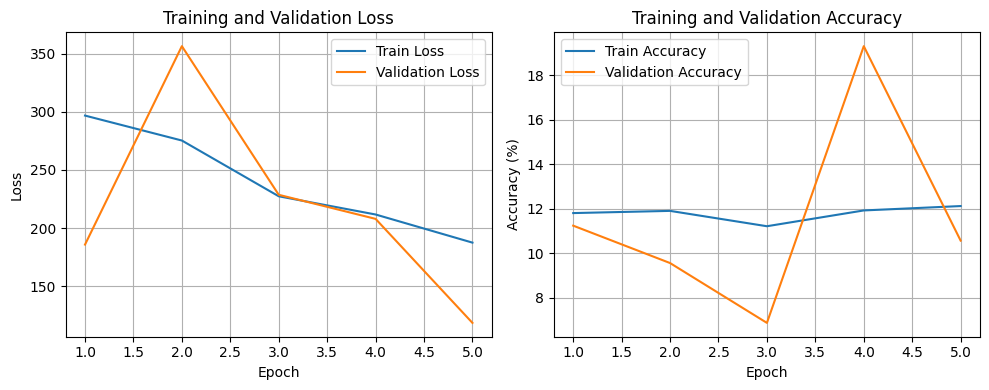

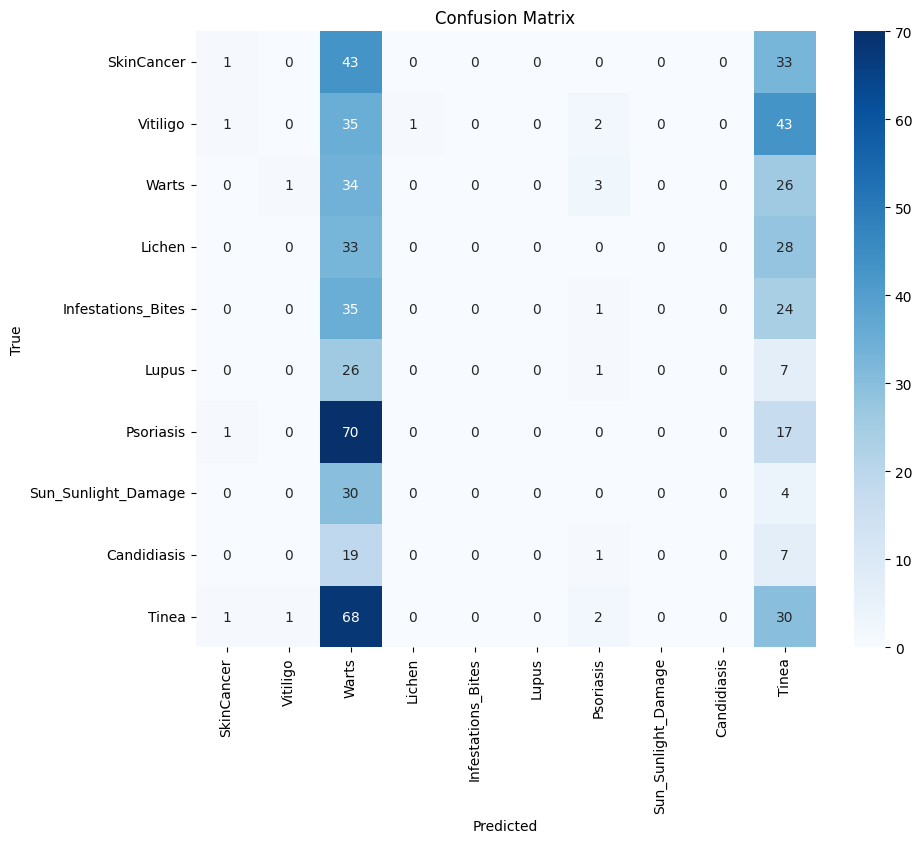

In [ ]:
class TanhNetwork(nn.Module):
    def __init__(self):
        super(TanhNetwork, self).__init__()
        self.fc1=nn.LazyLinear(8192)
        self.fc2=nn.LazyLinear(2048)
        self.fc3=nn.LazyLinear(512)
        self.fc4=nn.LazyLinear(10)
        self.conv1=nn.Conv2d(3, 16, 3)
        self.pool=nn.MaxPool2d(2, 2)
        self.activation=nn.Tanh()

    def forward(self, x):
        x=self.pool(self.activation(self.conv1(x)))
        x=x.view(x.size(0), -1)
        x=self.fc1(x)
        x=self.fc2(self.activation(x))
        x=self.fc3(self.activation(x))
        x=self.fc4(self.activation(x))
        return x

seed_everything(0)
torch.cuda.empty_cache()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=TanhNetwork().to(DEVICE)
runNN(model, DEVICE, os.path.join("resources", "resources", "SkinDisease(10 clases)"), 5, 16, torch.optim.Adam(model.parameters(), lr=1), torch.nn.CrossEntropyLoss(), transforms.Compose([transforms.ToPILImage(), transforms.Resize((82, 87)), transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

Se consigue corregir el comportamiento hasta cierto punto(se pasa de una respuesta a dos) pero los resultados siguen siendo peores que los de la red no convolutiva.

###Experimento 4: Eliminación del pooling

Para mejorar el porcentaje de acierto de la red, se elimina el pooling para obtener un mayor detalle en la salida de la capa convolutiva. Sin embargo, para poder evitar ocupar demasiada memoria de gpu es necesario reducir el tamaño de las imágenes

[Epoch 1] train_loss: 334.448 | train_acc: 11.10% | dev_loss: 433.226 | dev_acc: 13.93%
[Epoch 2] train_loss: 317.481 | train_acc: 11.12% | dev_loss: 333.948 | dev_acc: 10.57%
[Epoch 3] train_loss: 308.672 | train_acc: 11.77% | dev_loss: 257.428 | dev_acc: 14.26%
[Epoch 4] train_loss: 325.540 | train_acc: 11.26% | dev_loss: 273.848 | dev_acc: 11.07%
[Epoch 5] train_loss: 203.098 | train_acc: 11.35% | dev_loss: 259.397 | dev_acc: 8.39%
[Epoch 6] train_loss: 183.031 | train_acc: 10.61% | dev_loss: 104.783 | dev_acc: 16.95%
eval_acc: 14.47%


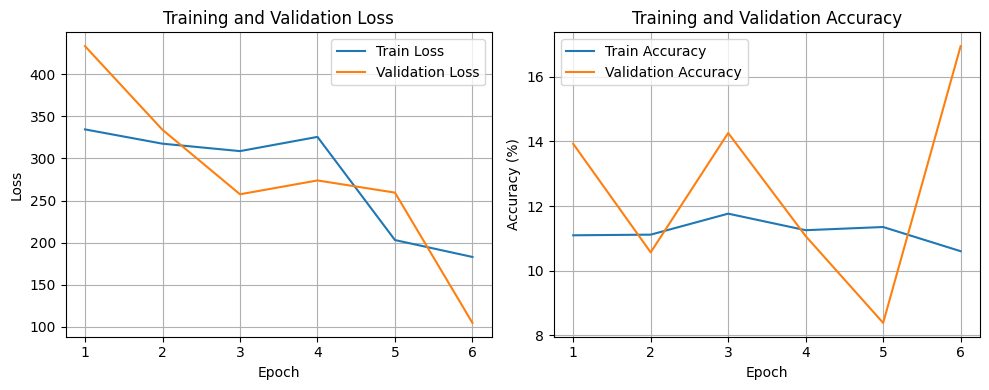

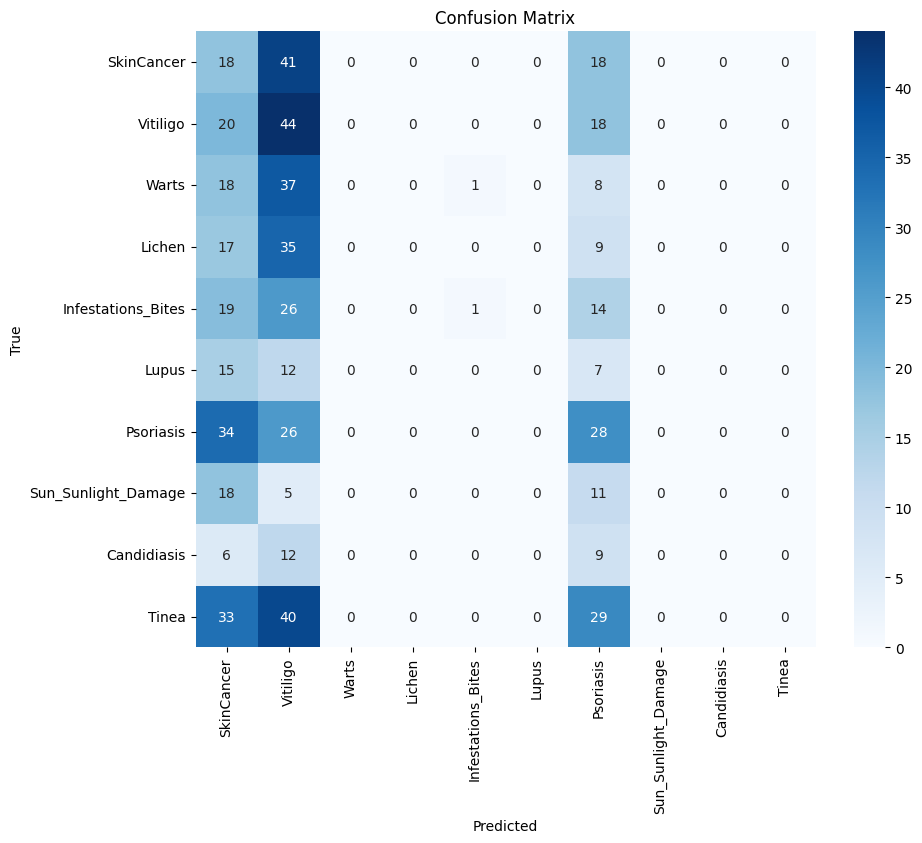

In [ ]:
class NoPoolNetwork(nn.Module):
    def __init__(self):
        super(NoPoolNetwork, self).__init__()
        self.fc1=nn.LazyLinear(8192)
        self.fc2=nn.LazyLinear(2048)
        self.fc3=nn.LazyLinear(512)
        self.fc4=nn.LazyLinear(10)
        self.conv1=nn.Conv2d(3, 16, 3)
        #self.pool=nn.MaxPool2d(2, 2)
        self.activation=nn.Tanh()

    def forward(self, x):
        x=self.activation(self.conv1(x))
        x=x.view(x.size(0), -1)
        x=self.fc1(x)
        x=self.fc2(self.activation(x))
        x=self.fc3(self.activation(x))
        x=self.fc4(self.activation(x))
        return x

seed_everything(0)
torch.cuda.empty_cache()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=NoPoolNetwork().to(DEVICE)
runNN(model, DEVICE, os.path.join("resources", "resources", "SkinDisease(10 clases)"), 6, 16, torch.optim.Adam(model.parameters(), lr=1), torch.nn.CrossEntropyLoss(), transforms.Compose([transforms.ToPILImage(), transforms.Resize((41, 43)), transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

Por primera vez se consigue superar a la red no convolutiva en el porcentaje de acierto en la evaluación. Además, se observa que el conjunto de respuestas es más variado.

###Experimento 5: Dropout

Se añaden capas de dropout, que desactivan un porcentaje de las neurones aleatoriamente, para así evitar la creación de sesgos e incentivizar el uso de todas la neuronas.

[Epoch 1] train_loss: 161.501 | train_acc: 11.69% | dev_loss: 279.512 | dev_acc: 14.26%
[Epoch 2] train_loss: 131.891 | train_acc: 11.90% | dev_loss: 238.707 | dev_acc: 11.58%
[Epoch 3] train_loss: 151.571 | train_acc: 11.90% | dev_loss: 99.239 | dev_acc: 6.54%
[Epoch 4] train_loss: 129.580 | train_acc: 11.28% | dev_loss: 115.002 | dev_acc: 14.77%
[Epoch 5] train_loss: 143.038 | train_acc: 12.16% | dev_loss: 236.687 | dev_acc: 10.07%
[Epoch 6] train_loss: 139.166 | train_acc: 12.02% | dev_loss: 127.935 | dev_acc: 16.28%
eval_acc: 15.90%


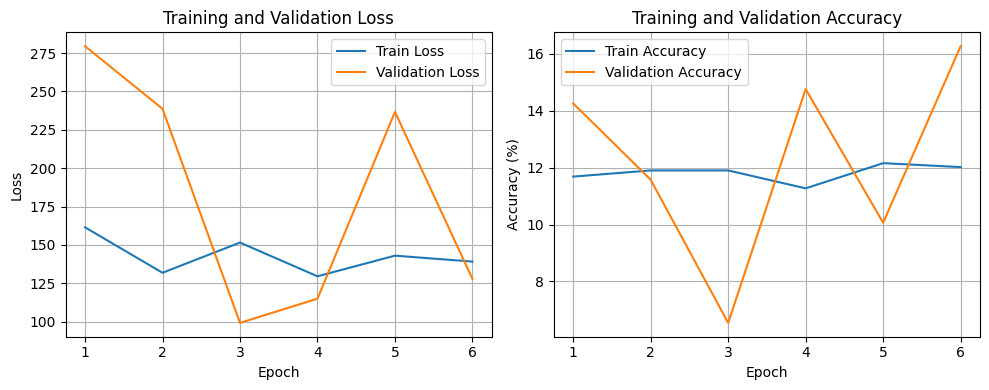

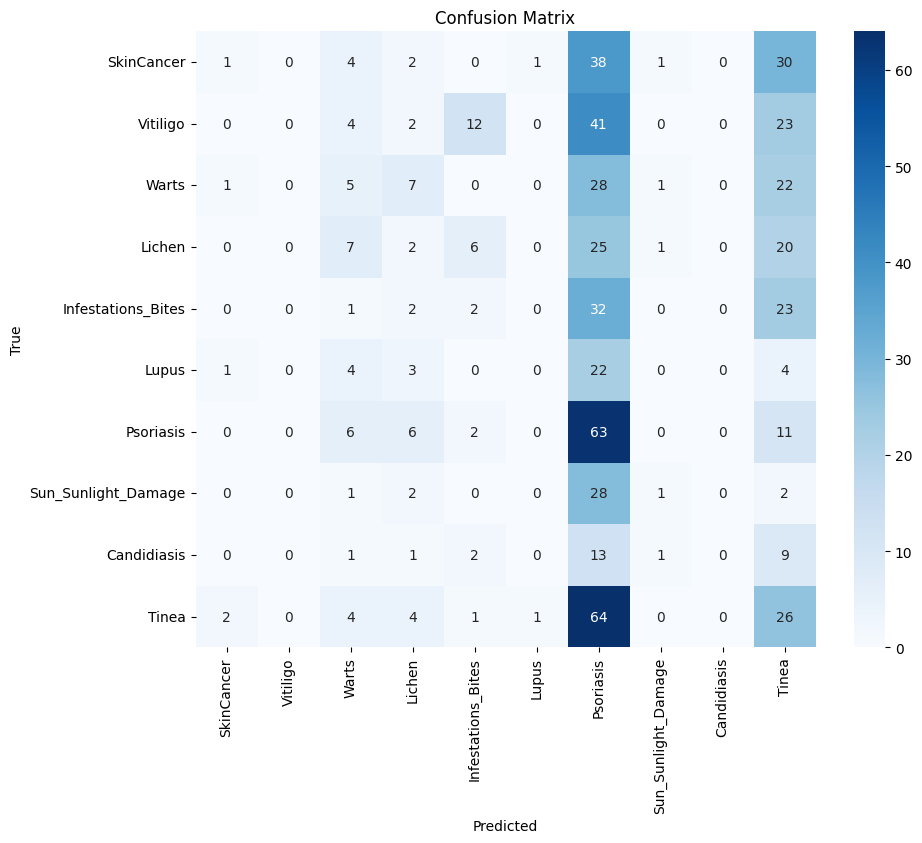

In [ ]:
class DropoutNetwork(nn.Module):
    def __init__(self):
        super(DropoutNetwork, self).__init__()
        self.fc1=nn.LazyLinear(8192)
        self.fc2=nn.LazyLinear(2048)
        self.fc3=nn.LazyLinear(512)
        self.fc4=nn.LazyLinear(10)
        self.conv1=nn.Conv2d(3, 16, 3)
        self.activation=nn.Tanh()
        self.dropout=nn.Dropout(0.2)

    def forward(self, x):
        x=self.activation(self.conv1(x))
        x=x.view(x.size(0), -1)
        x=self.fc1(x)
        x=self.dropout(x)
        x=self.fc2(self.activation(x))
        x=self.dropout(x)
        x=self.fc3(self.activation(x))
        x=self.dropout(x)
        x=self.fc4(self.activation(x))
        return x

seed_everything(0)
torch.cuda.empty_cache()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=DropoutNetwork().to(DEVICE)
runNN(model, DEVICE, os.path.join("resources", "resources", "SkinDisease(10 clases)"), 6, 16, torch.optim.Adam(model.parameters(), lr=1), torch.nn.CrossEntropyLoss(), transforms.Compose([transforms.ToPILImage(), transforms.Resize((41, 43)), transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

Se observa una mejoría en la perdida en los ratios de aciertos. En la matriz de confusión vuelven a aparecer dos respuestas principales, pero se observa que se distribuyen más respuestas en otras categorías, por lo que el sesgo hacia unas respuestas frente a otras a disminuido.

###Experimento 6: Ajuste de parámetros

Se ajustan el ratio de aprendizaje, el tamaño del batch y el número de epocas para intentar mejorar el rendimiento de la red creada, que en este caso es la misma que en el experimento anterior.

[Epoch 1] train_loss: 2.162 | train_acc: 23.12% | dev_loss: 2.029 | dev_acc: 31.38%
[Epoch 2] train_loss: 2.039 | train_acc: 26.92% | dev_loss: 2.042 | dev_acc: 28.69%
[Epoch 3] train_loss: 1.988 | train_acc: 29.22% | dev_loss: 1.934 | dev_acc: 30.87%
[Epoch 4] train_loss: 1.918 | train_acc: 32.70% | dev_loss: 1.899 | dev_acc: 34.73%
[Epoch 5] train_loss: 1.865 | train_acc: 34.53% | dev_loss: 1.886 | dev_acc: 34.06%
[Epoch 6] train_loss: 1.789 | train_acc: 37.64% | dev_loss: 1.907 | dev_acc: 33.72%
[Epoch 7] train_loss: 1.746 | train_acc: 38.47% | dev_loss: 2.015 | dev_acc: 31.71%
[Epoch 8] train_loss: 1.686 | train_acc: 41.44% | dev_loss: 1.906 | dev_acc: 35.57%
[Epoch 9] train_loss: 1.619 | train_acc: 43.45% | dev_loss: 1.841 | dev_acc: 39.09%
[Epoch 10] train_loss: 1.545 | train_acc: 46.50% | dev_loss: 1.895 | dev_acc: 38.26%
[Epoch 11] train_loss: 1.479 | train_acc: 49.11% | dev_loss: 1.890 | dev_acc: 36.91%
[Epoch 12] train_loss: 1.405 | train_acc: 51.79% | dev_loss: 1.910 | dev_a

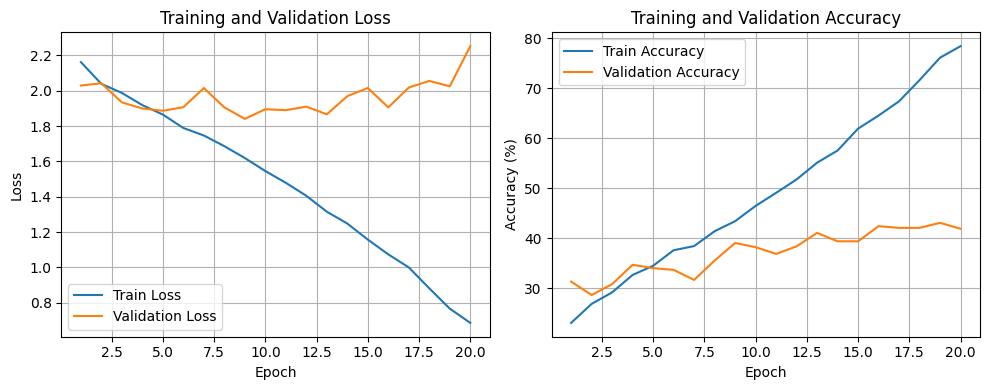

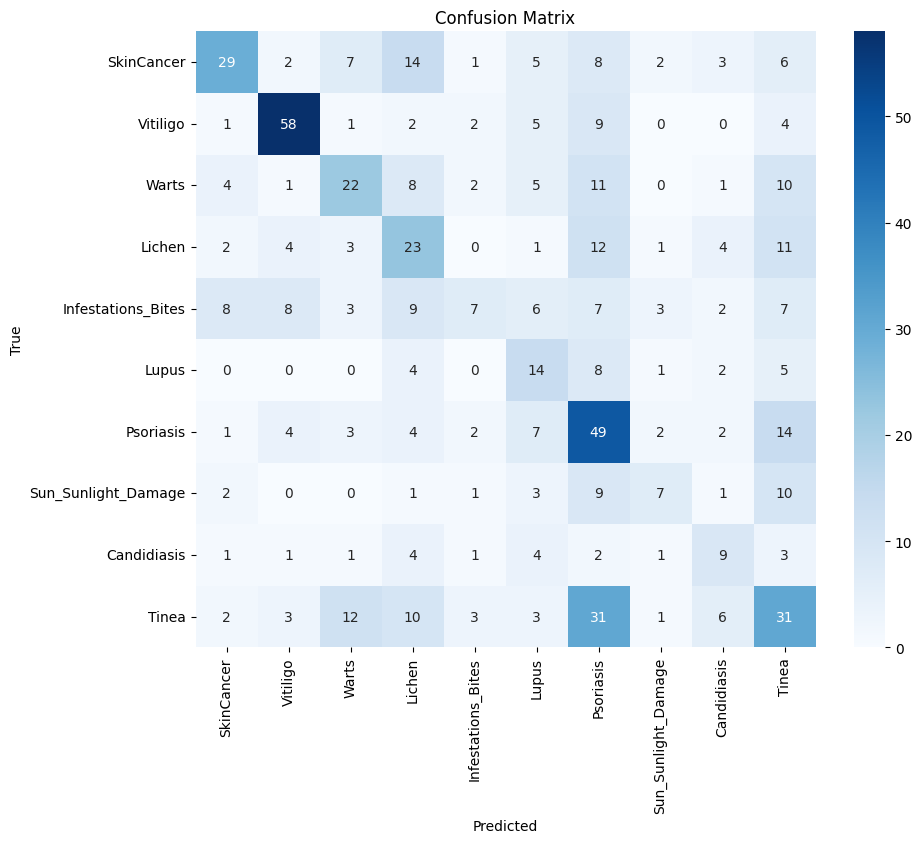

In [ ]:
class AdjustedNetwork(nn.Module):
    def __init__(self):
        super(AdjustedNetwork, self).__init__()
        self.fc1=nn.LazyLinear(8192)
        self.fc2=nn.LazyLinear(2048)
        self.fc3=nn.LazyLinear(512)
        self.fc4=nn.LazyLinear(10)
        self.conv1=nn.Conv2d(3, 16, 3)
        self.activation=nn.Tanh()
        self.dropout=nn.Dropout(0.2)

    def forward(self, x):
        x=self.activation(self.conv1(x))
        x=x.view(x.size(0), -1)
        x=self.fc1(x)
        x=self.dropout(x)
        x=self.fc2(self.activation(x))
        x=self.dropout(x)
        x=self.fc3(self.activation(x))
        x=self.dropout(x)
        x=self.fc4(self.activation(x))
        return x

seed_everything(0)
torch.cuda.empty_cache()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=AdjustedNetwork().to(DEVICE)
runNN(model, DEVICE, os.path.join("resources", "resources", "SkinDisease(10 clases)"), 20, 128, torch.optim.Adam(model.parameters(), lr=0.0001), torch.nn.CrossEntropyLoss(), transforms.Compose([transforms.ToPILImage(), transforms.Resize((41, 43)), transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

Se observa una mejoría significativa frente a las redes convolutivas anteriores, siendo la perdida por primer vez menor que la de la red no convolutiva. Se observa un salto significativo en el ratio de acierto y en la matriz de confusión empieza a destacar la diagonal principal(donde aparecen los aciertos). Cabe destacar que se observa una disparidad significativa entre el los resultados del conjunto de entrenamiento y el de evaluación (un 78% de acierto frente a un 39), lo cual se puede achacar a la organización del dataset.

###Experimento 7: Transfer learning

Para intentar obtener una mejor tasa se aplica transfer learning, que consiste en seleccionar una red preentrenada y modificar su capa de salida para utilizarla durante el entrenamiento. La red escogida es regnet_y_128f, con los pesos obtenidos de aplicarse sobre el conjunto de imágenes IMAGENET1K_SWAG_E2E_V1, escogida por ser una de las que tiene un mayor ratio de acierto en clasificación de imagenes en la librería torchvision (https://docs.pytorch.org/vision/main/models.html#classification). En este experimento se incluye un print del modelo para poder observar las distintas capas, que en los anteriores ya eran visibles al estar definidas en el propio código.

Downloading: "https://download.pytorch.org/models/regnet_y_128gf_swag-c8ce3e52.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_128gf_swag-c8ce3e52.pth


100%|██████████| 2.40G/2.40G [01:03<00:00, 40.5MB/s]


RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 528, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(528, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 528, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(528, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(528, 528, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=2, bias=False)
      

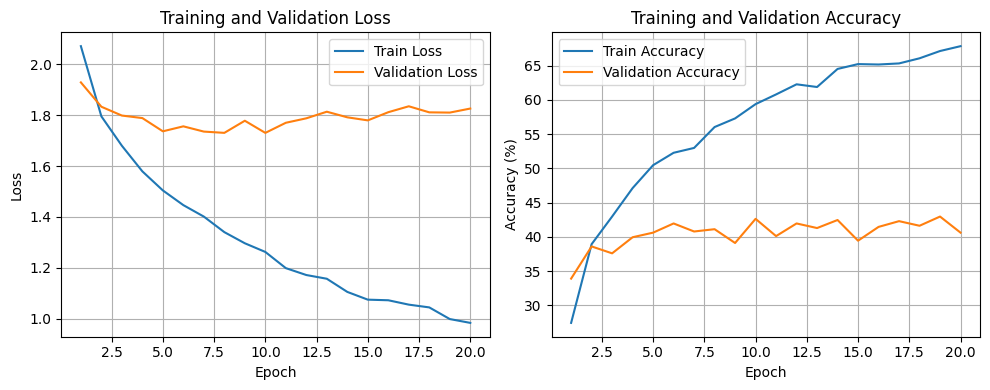

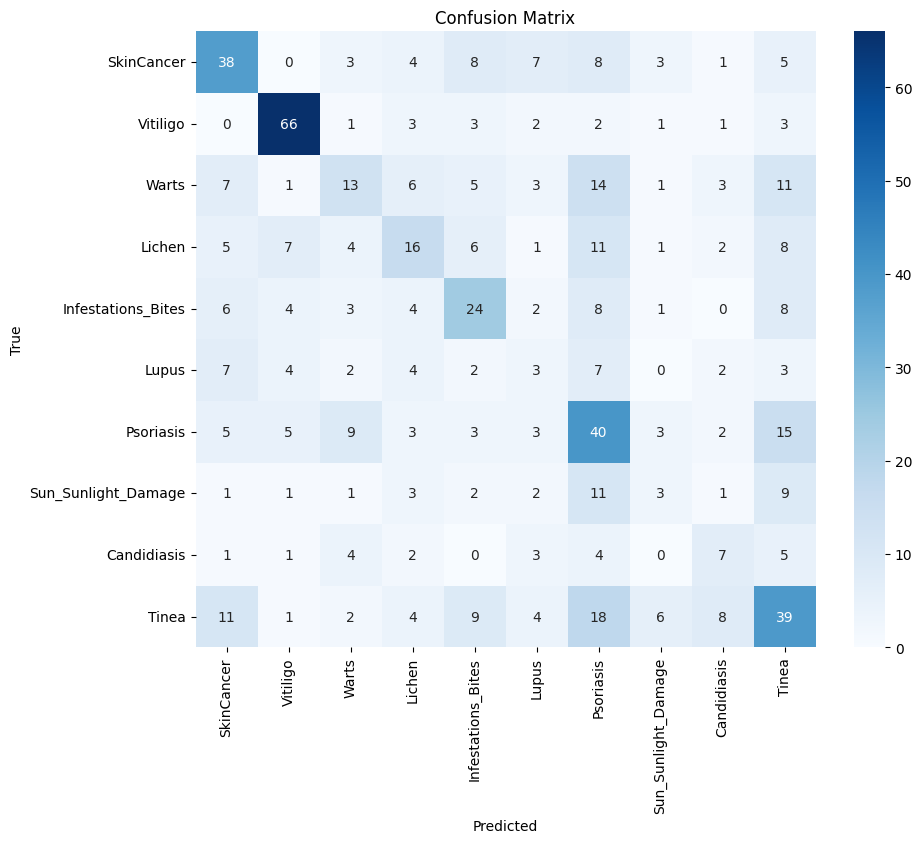

In [ ]:
seed_everything(0)
torch.cuda.empty_cache()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=models.regnet_y_128gf(weights="IMAGENET1K_SWAG_E2E_V1")
for param in model.parameters():
    param.requires_grad = False
model.fc=nn.Sequential(
    nn.LazyLinear(512),
    nn.Tanh(),
    nn.Dropout(0.2),
    nn.LazyLinear(10)
)
model.to(DEVICE)
print(model)
runNN(model, DEVICE, os.path.join("resources", "resources", "SkinDisease(10 clases)"), 20, 128, torch.optim.Adam(model.parameters(), lr=0.0001), torch.nn.CrossEntropyLoss(), transforms.Compose([transforms.ToPILImage(), transforms.Resize((41, 43)), transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

Se observan unos resultados muy similares al anterior experimento, por lo que no se obtienen nuevas conclusiones.

### Experimento 8
En este experimento se aplican las redes creadas anteriormente sobre el dataset de 22 clases para observar su rendimiento.

####Red creada durante el proyecto

[Epoch 1] train_loss: 2.733 | train_acc: 18.85% | dev_loss: 2.637 | dev_acc: 22.08%
[Epoch 2] train_loss: 2.586 | train_acc: 22.86% | dev_loss: 2.619 | dev_acc: 22.47%
[Epoch 3] train_loss: 2.500 | train_acc: 25.18% | dev_loss: 2.551 | dev_acc: 25.50%
[Epoch 4] train_loss: 2.444 | train_acc: 26.31% | dev_loss: 2.544 | dev_acc: 25.56%
[Epoch 5] train_loss: 2.380 | train_acc: 28.33% | dev_loss: 2.554 | dev_acc: 25.69%
[Epoch 6] train_loss: 2.325 | train_acc: 29.84% | dev_loss: 2.517 | dev_acc: 26.15%
[Epoch 7] train_loss: 2.257 | train_acc: 31.71% | dev_loss: 2.502 | dev_acc: 26.99%
[Epoch 8] train_loss: 2.196 | train_acc: 34.00% | dev_loss: 2.407 | dev_acc: 29.37%
[Epoch 9] train_loss: 2.114 | train_acc: 35.92% | dev_loss: 2.373 | dev_acc: 30.34%
[Epoch 10] train_loss: 2.040 | train_acc: 38.12% | dev_loss: 2.461 | dev_acc: 30.60%
[Epoch 11] train_loss: 1.973 | train_acc: 40.24% | dev_loss: 2.423 | dev_acc: 31.83%
[Epoch 12] train_loss: 1.887 | train_acc: 42.50% | dev_loss: 2.524 | dev_a

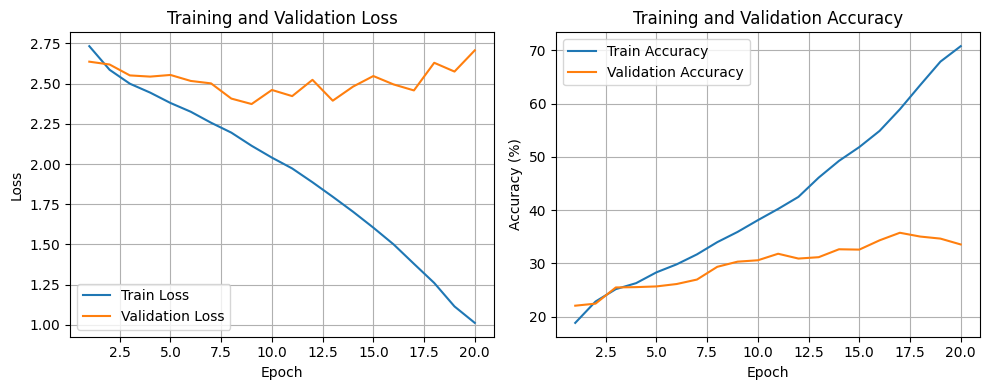

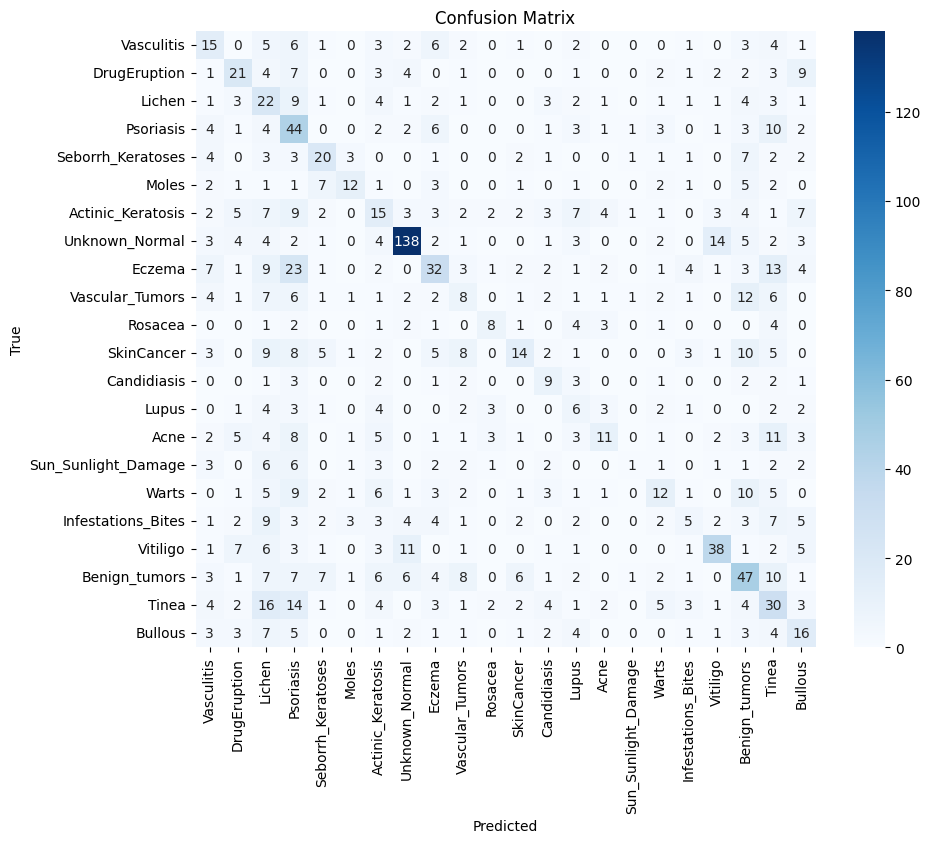

In [ ]:
class AdjustedNetwork(nn.Module):
    def __init__(self):
        super(AdjustedNetwork, self).__init__()
        self.fc1=nn.LazyLinear(8192)
        self.fc2=nn.LazyLinear(2048)
        self.fc3=nn.LazyLinear(512)
        self.fc4=nn.LazyLinear(22)
        self.conv1=nn.Conv2d(3, 16, 3)
        self.activation=nn.Tanh()
        self.dropout=nn.Dropout(0.2)

    def forward(self, x):
        x=self.activation(self.conv1(x))
        x=x.view(x.size(0), -1)
        x=self.fc1(x)
        x=self.dropout(x)
        x=self.fc2(self.activation(x))
        x=self.dropout(x)
        x=self.fc3(self.activation(x))
        x=self.dropout(x)
        x=self.fc4(self.activation(x))
        return x

seed_everything(0)
torch.cuda.empty_cache()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=AdjustedNetwork().to(DEVICE)
runNN(model, DEVICE, os.path.join("resources", "resources", "SkinDisease(22 clases)"), 20, 128, torch.optim.Adam(model.parameters(), lr=0.0001), torch.nn.CrossEntropyLoss(), transforms.Compose([transforms.ToPILImage(), transforms.Resize((41, 43)), transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

####Red usando Transfer learning

Downloading: "https://download.pytorch.org/models/regnet_y_128gf_swag-c8ce3e52.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_128gf_swag-c8ce3e52.pth


100%|██████████| 2.40G/2.40G [00:11<00:00, 234MB/s]


RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 528, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(528, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 528, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(528, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(528, 528, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=2, bias=False)
      

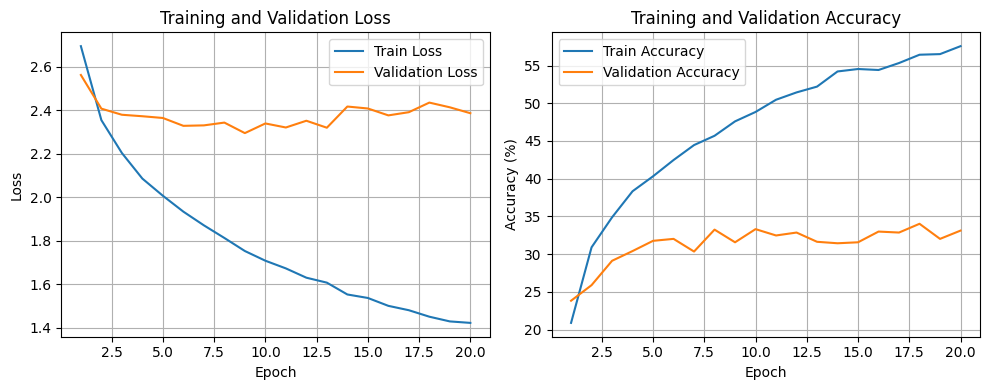

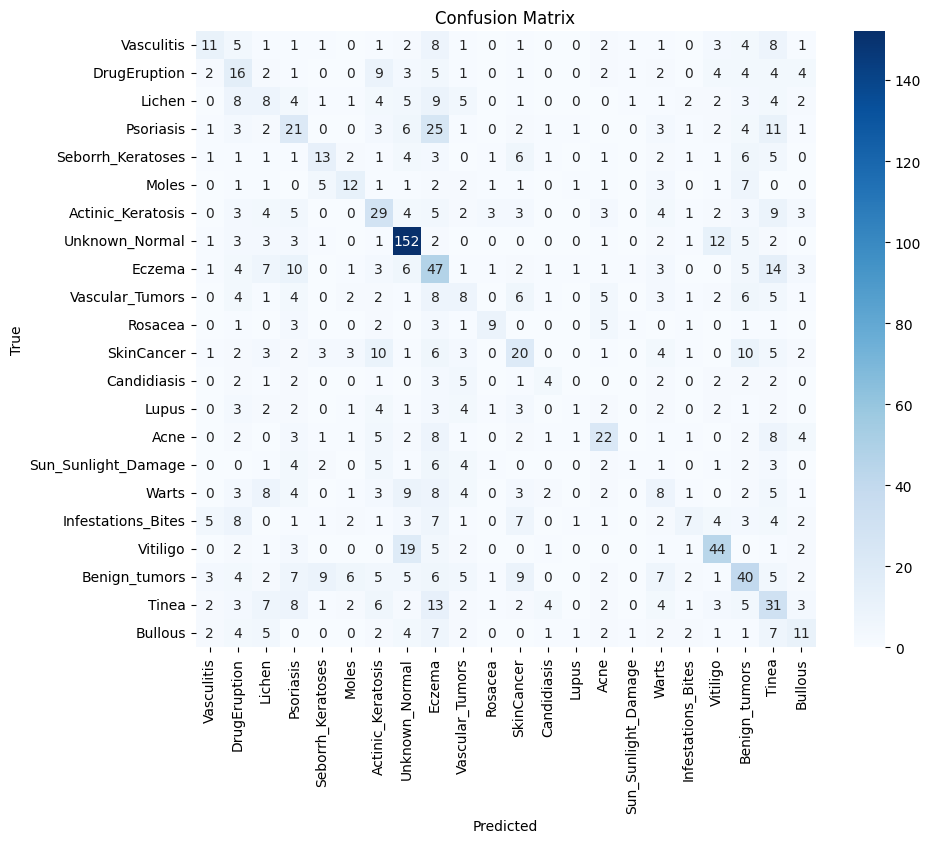

In [ ]:
seed_everything(0)
torch.cuda.empty_cache()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=models.regnet_y_128gf(weights="IMAGENET1K_SWAG_E2E_V1")
for param in model.parameters():
    param.requires_grad = False
model.fc=nn.Sequential(
    nn.LazyLinear(512),
    nn.Tanh(),
    nn.Dropout(0.2),
    nn.LazyLinear(22)
)
model.to(DEVICE)
print(model)
runNN(model, DEVICE, os.path.join("resources", "resources", "SkinDisease(22 clases)"), 20, 128, torch.optim.Adam(model.parameters(), lr=0.0001), torch.nn.CrossEntropyLoss(), transforms.Compose([transforms.ToPILImage(), transforms.Resize((41, 43)), transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

Se observa un ligero empeoramiento en ambas redes, esperable debido al aumento del tamaño del problema, además de una ligera ventaja de la red de transfer learning sobre la creada.

##Experimento 9: Reorganización de los datos

Para intentar solucionar el overfitting presente en los modelos anteriores, se reorganiza el dataset para reducir las diferencias que existan entre los distintos conjuntos de dato (train, test y validation). El script ejecutado para realizar esta reorganización se encuentra en el repositorio del proyecto. Adicionalmente, se aumenta el número de épocas ya que observando las gráficas de perdida y porcentaje de acierto se observa que los resultados sobre el conjunto de entrenamiento aún pueden mejorar.

###Red creada durante el proyecto

[Epoch 1] train_loss: 2.720 | train_acc: 19.16% | dev_loss: 2.674 | dev_acc: 21.35%
[Epoch 2] train_loss: 2.582 | train_acc: 22.67% | dev_loss: 2.592 | dev_acc: 22.70%
[Epoch 3] train_loss: 2.502 | train_acc: 24.55% | dev_loss: 2.571 | dev_acc: 23.38%
[Epoch 4] train_loss: 2.441 | train_acc: 26.77% | dev_loss: 2.518 | dev_acc: 26.15%
[Epoch 5] train_loss: 2.370 | train_acc: 28.79% | dev_loss: 2.476 | dev_acc: 27.50%
[Epoch 6] train_loss: 2.306 | train_acc: 31.29% | dev_loss: 2.451 | dev_acc: 27.64%
[Epoch 7] train_loss: 2.246 | train_acc: 32.11% | dev_loss: 2.428 | dev_acc: 27.77%
[Epoch 8] train_loss: 2.190 | train_acc: 33.84% | dev_loss: 2.426 | dev_acc: 29.46%
[Epoch 9] train_loss: 2.110 | train_acc: 36.14% | dev_loss: 2.449 | dev_acc: 28.99%
[Epoch 10] train_loss: 2.031 | train_acc: 38.75% | dev_loss: 2.395 | dev_acc: 29.66%
[Epoch 11] train_loss: 1.945 | train_acc: 41.38% | dev_loss: 2.430 | dev_acc: 30.07%
[Epoch 12] train_loss: 1.873 | train_acc: 43.62% | dev_loss: 2.436 | dev_a

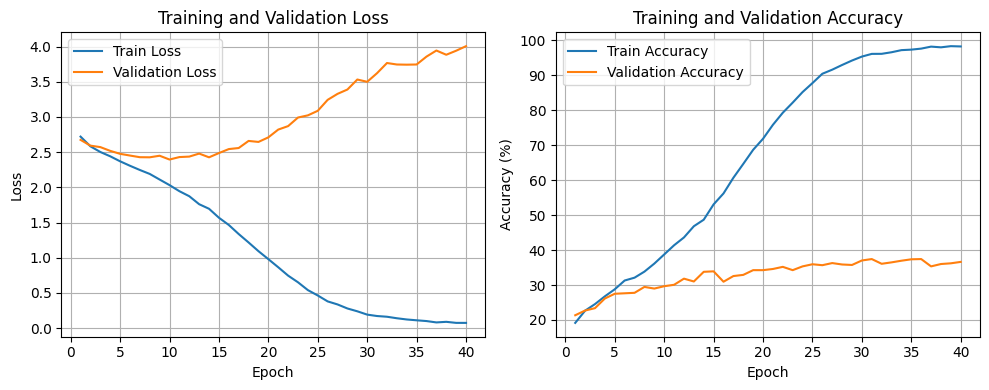

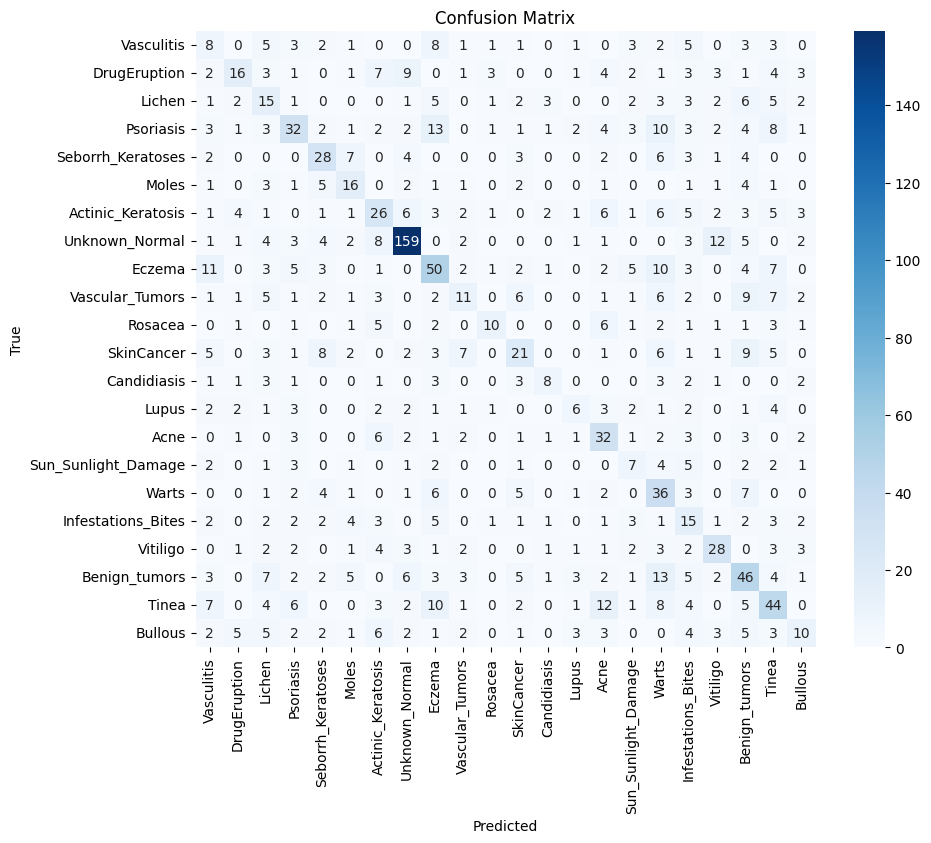

In [ ]:
class AdjustedNetwork(nn.Module):
    def __init__(self):
        super(AdjustedNetwork, self).__init__()
        self.fc1=nn.LazyLinear(8192)
        self.fc2=nn.LazyLinear(2048)
        self.fc3=nn.LazyLinear(512)
        self.fc4=nn.LazyLinear(22)
        self.conv1=nn.Conv2d(3, 16, 3)
        self.activation=nn.Tanh()
        self.dropout=nn.Dropout(0.2)

    def forward(self, x):
        x=self.activation(self.conv1(x))
        x=x.view(x.size(0), -1)
        x=self.fc1(x)
        x=self.dropout(x)
        x=self.fc2(self.activation(x))
        x=self.dropout(x)
        x=self.fc3(self.activation(x))
        x=self.dropout(x)
        x=self.fc4(self.activation(x))
        return x

seed_everything(0)
torch.cuda.empty_cache()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=AdjustedNetwork().to(DEVICE)
runNN(model, DEVICE, os.path.join("resources", "resources", "SkinDisease(22 clases) reorganizado"), 40, 128, torch.optim.Adam(model.parameters(), lr=0.0001), torch.nn.CrossEntropyLoss(), transforms.Compose([transforms.ToPILImage(), transforms.Resize((41, 43)), transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

###Red usando transfer learning

Downloading: "https://download.pytorch.org/models/regnet_y_128gf_swag-c8ce3e52.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_128gf_swag-c8ce3e52.pth


100%|██████████| 2.40G/2.40G [02:27<00:00, 17.5MB/s]


RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 528, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(528, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 528, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(528, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(528, 528, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=2, bias=False)
      

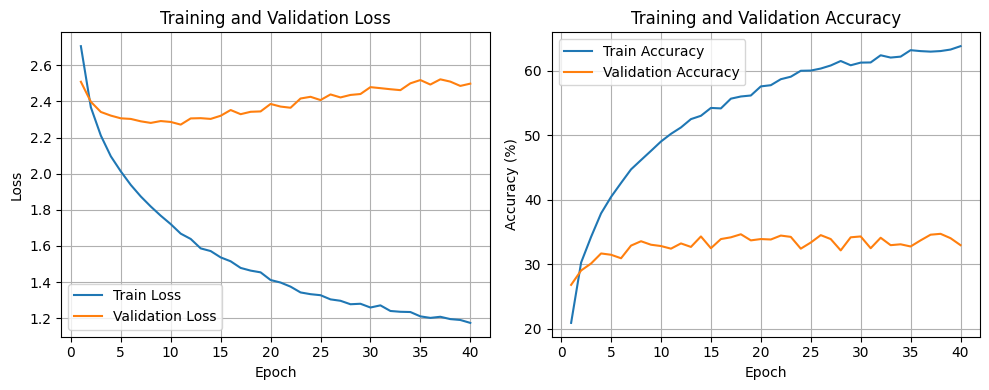

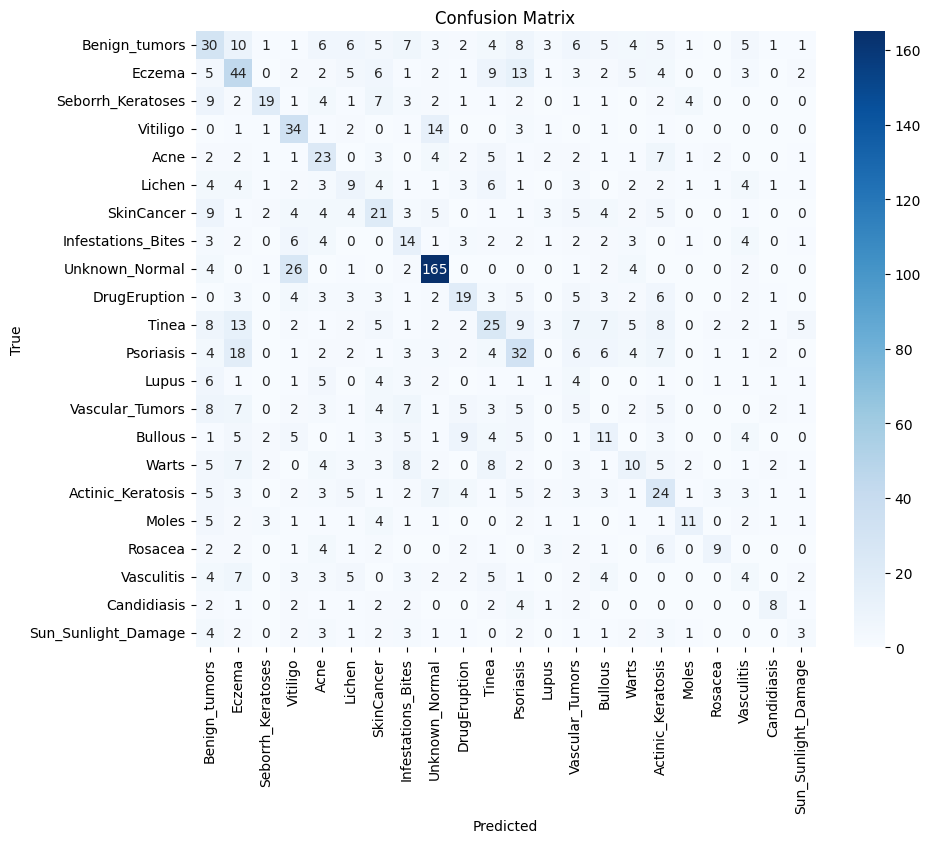

In [ ]:
seed_everything(0)
torch.cuda.empty_cache()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=models.regnet_y_128gf(weights="IMAGENET1K_SWAG_E2E_V1")
for param in model.parameters():
    param.requires_grad = False
model.fc=nn.Sequential(
    nn.LazyLinear(512),
    nn.Tanh(),
    nn.Dropout(0.2),
    nn.LazyLinear(22)
)
model.to(DEVICE)
print(model)
runNN(model, DEVICE, os.path.join("resources", "resources", "SkinDisease(22 clases) reorganizado"), 40, 128, torch.optim.Adam(model.parameters(), lr=0.0001), torch.nn.CrossEntropyLoss(), transforms.Compose([transforms.ToPILImage(), transforms.Resize((41, 43)), transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

Se observan resultados mejores a los anteriores, pero sigue existiendo un overfitting significativo.

##Experimento 10: Data augmentation

Puesto que sigue existiendo un overfitting significativo, se aplican técnicas de data augmentation sobre los datos para aumentar el conjunto y variedad de los datos de entrenamiento. Cabe destacar que las técnicas aplicadas actúan sobre la posición de la imagen (inversión vertical y horizontal), no aplicandose cambios sobre el color de estas. Esto se debe a que el color de la zona afectada puede ser importante para el diagnóstico de una enfermedad dermatológica (un grano blanco y un grano rojo pueden ser síntomas de enfermedades distintas), por lo que modificar los colores de la imagen puede causar que se pierdan detalles importantes para el diagnóstico, empeorando el rendimiento de la red.
Adicionalmente se sustituye la función de activación por la función ReLU para obtener un mayor rendimiento.

[Epoch 1] train_loss: 2.735 | train_acc: 18.35% | dev_loss: 2.619 | dev_acc: 21.82%
[Epoch 2] train_loss: 2.571 | train_acc: 22.33% | dev_loss: 2.522 | dev_acc: 23.45%
[Epoch 3] train_loss: 2.500 | train_acc: 23.69% | dev_loss: 2.481 | dev_acc: 24.86%
[Epoch 4] train_loss: 2.439 | train_acc: 25.22% | dev_loss: 2.434 | dev_acc: 26.08%
[Epoch 5] train_loss: 2.404 | train_acc: 26.50% | dev_loss: 2.385 | dev_acc: 26.49%
[Epoch 6] train_loss: 2.351 | train_acc: 27.97% | dev_loss: 2.366 | dev_acc: 27.36%
[Epoch 7] train_loss: 2.319 | train_acc: 28.72% | dev_loss: 2.325 | dev_acc: 28.92%
[Epoch 8] train_loss: 2.270 | train_acc: 29.91% | dev_loss: 2.312 | dev_acc: 29.66%
[Epoch 9] train_loss: 2.237 | train_acc: 31.18% | dev_loss: 2.279 | dev_acc: 30.14%
[Epoch 10] train_loss: 2.193 | train_acc: 32.81% | dev_loss: 2.278 | dev_acc: 29.73%
[Epoch 11] train_loss: 2.159 | train_acc: 33.40% | dev_loss: 2.264 | dev_acc: 30.61%
[Epoch 12] train_loss: 2.114 | train_acc: 35.05% | dev_loss: 2.216 | dev_a

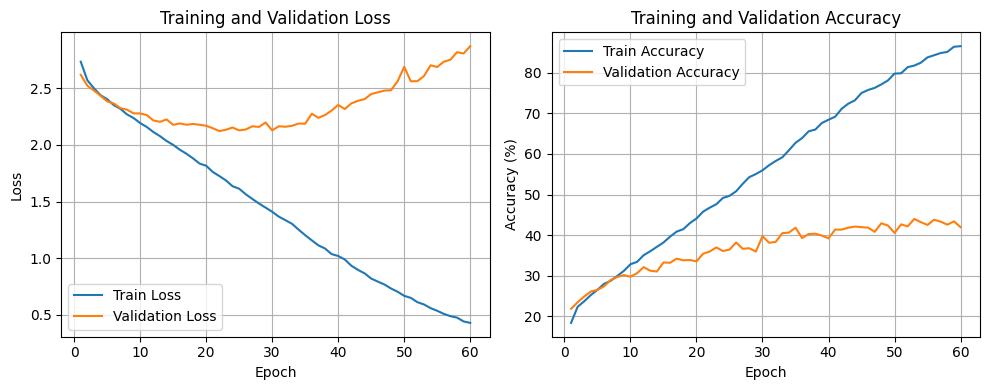

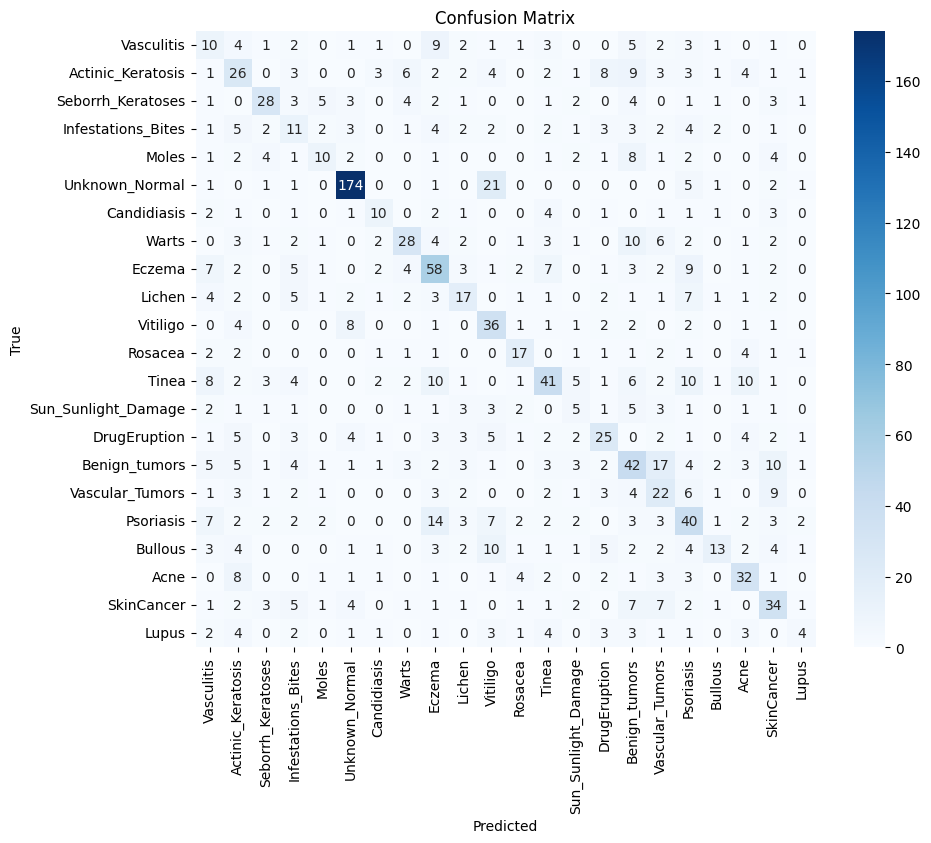

In [7]:
class AdjustedNetwork(nn.Module):
    def __init__(self):
        super(AdjustedNetwork, self).__init__()
        self.fc1=nn.LazyLinear(8192)
        self.fc2=nn.LazyLinear(2048)
        self.fc3=nn.LazyLinear(512)
        self.fc4=nn.LazyLinear(22)
        self.conv1=nn.Conv2d(3, 16, 3)
        self.activation=nn.ReLU()
        self.dropout=nn.Dropout(0.2)

    def forward(self, x):
        x=self.activation(self.conv1(x))
        x=x.view(x.size(0), -1)
        x=self.fc1(x)
        x=self.dropout(x)
        x=self.fc2(self.activation(x))
        x=self.dropout(x)
        x=self.fc3(self.activation(x))
        x=self.dropout(x)
        x=self.fc4(self.activation(x))
        return x

seed_everything(0)
torch.cuda.empty_cache()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=AdjustedNetwork().to(DEVICE)
runNN(model, DEVICE, os.path.join("resources", "resources", "SkinDisease(22 clases) reorganizado"), 60, 128, torch.optim.Adam(model.parameters(), lr=0.0001), torch.nn.CrossEntropyLoss(), transforms.Compose([transforms.ToPILImage(), transforms.Resize((41, 43)), transforms.RandomHorizontalFlip(p=0.5), transforms.RandomVerticalFlip(p=0.5), transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 528, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(528, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 528, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(528, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(528, 528, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=2, bias=False)
      

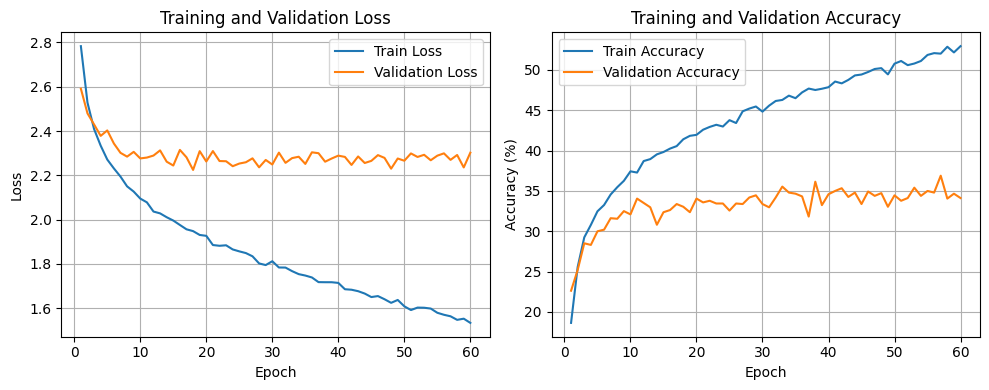

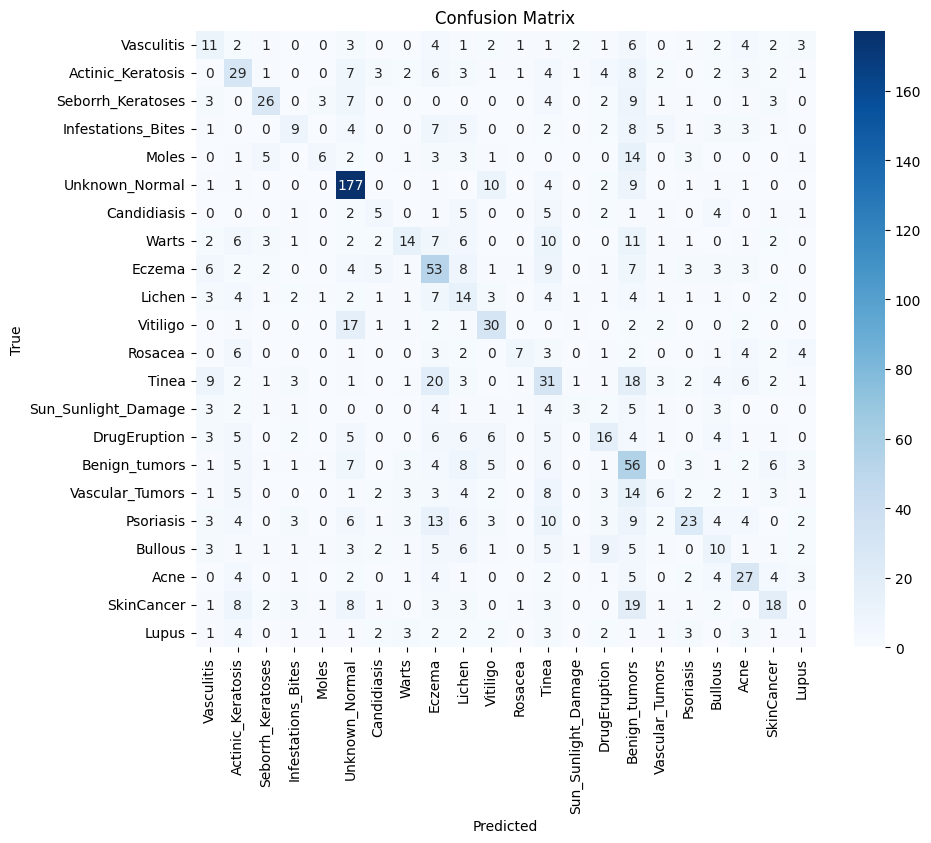

In [8]:
seed_everything(0)
torch.cuda.empty_cache()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=models.regnet_y_128gf(weights="IMAGENET1K_SWAG_E2E_V1")
for param in model.parameters():
    param.requires_grad = False
model.fc=nn.Sequential(
    nn.LazyLinear(512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.LazyLinear(22)
)
model.to(DEVICE)
print(model)
runNN(model, DEVICE, os.path.join("resources", "resources", "SkinDisease(22 clases) reorganizado"), 60, 128, torch.optim.Adam(model.parameters(), lr=0.0001), torch.nn.CrossEntropyLoss(), transforms.Compose([transforms.ToPILImage(), transforms.Resize((41, 43)), transforms.RandomHorizontalFlip(p=0.5), transforms.RandomVerticalFlip(p=0.5),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

Se mejora la tasa de acierto significativamente. Sin embargo, aún sigue existiendo un overfitting significativo.

##Conclusión

Durante el desarrollo de este proyecto no ha sido posible obtener una red que consiga clasificar las imágenes de forma fiable (lo máximo que se ha obtenido ha sido un 44% en evaluación), observándose un problema de overfitting persistente en los modelos desarrollados. Para poder mejorar el rendimiento del modelo, es necesario eliminar este problema, lo cuál podría conseguirse mediante un data set más amplio o aplicando más técnicas de data augmentation.